In [19]:
#import packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Concatenate, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from numpy.lib.stride_tricks import sliding_window_view
from keras_efficient_kan import KANLinear

import keras
from keras import ops

In [20]:
model = keras.models.load_model('../model_testing/kan_logistic_binary_6.keras')

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="../report/figures/model_summary/logistic_6.png", show_shapes=True)


In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Concatenate, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from numpy.lib.stride_tricks import sliding_window_view
from keras_efficient_kan import KANLinear

import keras
from keras import ops

# ── TARGET VARIABLE ───────────────────────────────────────────────────────────
TARGET_VAR = 'bool_48'


# ── HYPERPARAMETERS ───────────────────────────────────────────────────────────
WEATHER_CSV   = "../data/clean/rolling_sums.csv"
STATIONS_CSV  = "../data/clean/valais_stations.csv"
HIST_LEN      =  3   # history window
HORIZON       = 6     # sum_6 target
BATCH_SIZE    = 64
EMB_DIM       = 4
KAN_HID       = 64
KAN_GRID      = 3
KAN_K         = 3
LR            = 1e-3
EPOCHS        = 20

# ── 1) LOAD & MERGE ────────────────────────────────────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV, parse_dates=["time"])

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(
    df_stations[["station","east","north","altitude"]],
    on="station", how="left"
)

# ── 2) ENCODE & SCALE ──────────────────────────────────────────────────────────
df["station_idx"] = LabelEncoder().fit_transform(df["station"])
n_stations = df["station_idx"].nunique()

# static
stat_df = (
    df[["station_idx","east","north","altitude"]]
    .drop_duplicates()
    .set_index("station_idx")
    .astype(np.float32)
)
stat_df[:] = StandardScaler().fit_transform(stat_df)

# dynamic
dyn_cols = ["precip","east_wind","north_wind","moisture","pressure","temperature"]
df[dyn_cols] = StandardScaler().fit_transform(df[dyn_cols])

# helper for time features
def make_time_feats(ts):
    return [ts.hour/23.0, ts.weekday()/6.0, ts.month/12.0]

# sort by station and time_id
df = df.sort_values(["station_idx", "time"]).reset_index(drop=True)

# grab raw numpy arrays
target_vals  = df[TARGET_VAR].values.astype(np.float32)

dyn_vals   = df[dyn_cols].values.astype(np.float32)
ds_vals    = df["time"].values           
sidx_vals  = df["station_idx"].values.astype(np.int32)

# ── 3) BUILD WINDOWS per‐station ───────────────────────────────────────────────
X_hist, X_stat, X_time, X_sid, y_list = [], [], [], [], []

for sidx, grp in df.groupby("station_idx", sort=False):
    idx = grp.index.values
    arr_dyn = dyn_vals[idx]  

    # sliding windows of shape [T-HIST_LEN+1, HIST_LEN, D_dyn]
    win = sliding_window_view(arr_dyn, window_shape=(HIST_LEN, arr_dyn.shape[1]))
    win = win.reshape(-1, HIST_LEN, arr_dyn.shape[1])

    # targets & time at end of each window
    targs = target_vals[idx][HIST_LEN-1:]
    times = ds_vals  [idx][HIST_LEN-1:]

    # time‐of‐day feats
    time_feat = np.stack([ make_time_feats(pd.to_datetime(t)) for t in times ], axis=0)

    # static feats repeated
    sf = np.repeat(stat_df.loc[sidx].values[None,:], len(targs), axis=0)

    # station idx array
    sid = np.full(len(targs), sidx, dtype=np.int32)

    X_hist.append(win)
    X_time.append(time_feat)
    X_stat.append(sf)
    X_sid.append(sid)
    y_list.append(targs)

# concat all stations
X_hist = np.vstack(X_hist) 
X_time = np.vstack(X_time) 
X_stat = np.vstack(X_stat) 
X_sid  = np.concatenate(X_sid) 
y_all  = np.concatenate(y_list)

# ── 4) TRAIN/VAL/TEST SPLIT (by date quantile) ────────────────────────────────
q1, q2 = df["time"].quantile([0.6,0.8])
mask = np.concatenate([
    pd.to_datetime(ds_vals[df.groupby("station_idx", sort=False).get_group(sidx).index][HIST_LEN-1:])
    for sidx in sorted(df["station_idx"].unique())
])

train_idx = np.where(mask <= q1)[0]
val_idx   = np.where((mask>q1)&(mask<=q2))[0]
test_idx  = np.where(mask > q2)[0]

def make_ds(idxs):
    return (
       tf.data.Dataset.from_tensor_slices((
            {
                "hist"   : X_hist[idxs],
                "stat"   : X_stat[idxs],
                "time"   : X_time[idxs],
                "station": X_sid[idxs],
            },
            y_all[idxs]
        ))
        .shuffle(10_000)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

train_ds = make_ds(train_idx)
val_ds   = make_ds(val_idx)
test_ds  = make_ds(test_idx)

In [34]:
probs = model.predict(test_ds) 
preds = (probs > 0.5).astype(int).flatten()

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

6573/6573 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


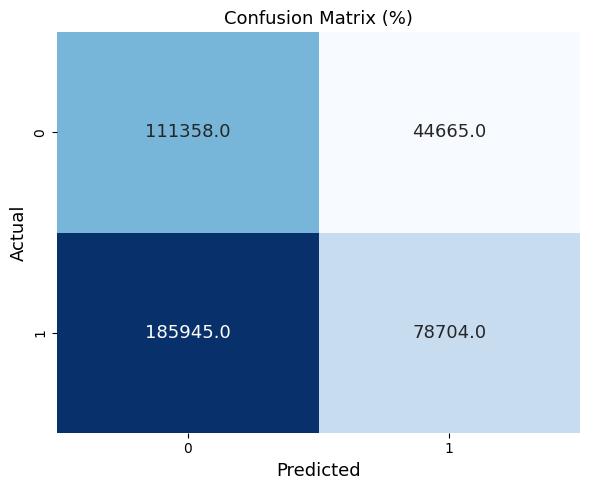

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, preds)

cm_percent = cm.astype('float') / cm.sum() * 100

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=["0", "1"], yticklabels=["0", "1"],
            annot_kws={"fontsize": 13})
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix (%)", fontsize=13)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/logistic_48_confmat.pdf')
plt.show()

Accuracy         : 0.4518
Balanced Accuracy: 0.5056
AUC              : 0.5085


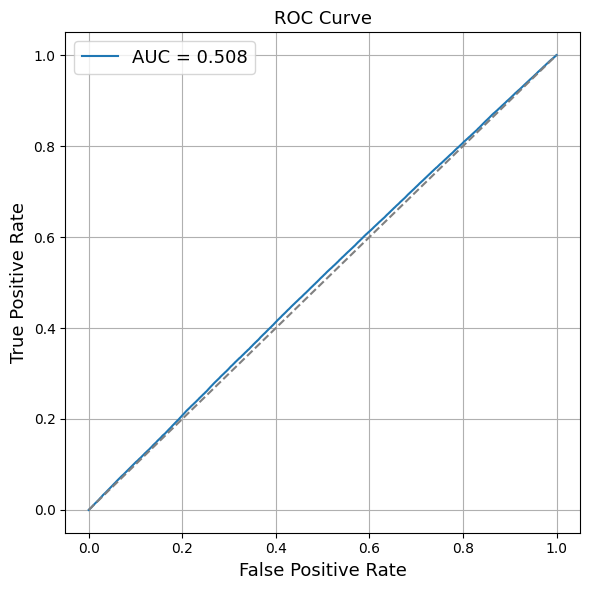

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score, balanced_accuracy_score

preds = (probs > 0.5).astype(int).flatten()

# 2. Accuracy metrics
acc = accuracy_score(y_true, preds)
bacc = balanced_accuracy_score(y_true, preds)
auc = roc_auc_score(y_true, probs)

print(f"Accuracy         : {acc:.4f}")
print(f"Balanced Accuracy: {bacc:.4f}")
print(f"AUC              : {auc:.4f}")

# 3. ROC curve
fpr, tpr, thresholds = roc_curve(y_true, probs)

# 4. Plot ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("ROC Curve", fontsize=13)
plt.legend(fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.hist(probs, bins=50)
plt.title("Predicted Probabilities")
plt.xlabel("P(y=1)")
plt.ylabel("Count")
plt.show()

In [ ]:
from collections import Counter
print(Counter(y_all))